------------------------------------------------------------
### Course Project PCQI: Time-Dependent processes with Neural Quantum States
------------------------------------------------------------
This notebook is part of the course project for PCQI 2022.
By Pim Veefkind (XXXXXXX) & Thomas Rothe (1930443)

Set-up of basic NQS framework & implementation of time evolution + evaluation of expectations


---------------------------------------------------
#### Basic set-up of NQS:

In [1]:
import numpy as np
import pickle
from tqdm import tqdm
import os
import sys

#import scipy.sparse as sp
np.random.seed(12)

def sigmoid(X):
    return 1./(np.exp(X)+1)

#### Time-independent RBM NQS:

In [67]:
from dataclasses import dataclass, field

@dataclass
class TFIM:
    h: float #Transverse field strength
    g: float #Ratio of transverse field / interaction strengths
    J: str = field(init=False) #Implied interaction strength
    
    def __post_init__(self):
        self.J = self.h / self.g


class NQS_RBM:
    
    def __init__(self, hamilt, Nv,Nh):
        self.hamilt = hamilt
        self.Nv = Nv
        self.Nh = Nh
        self.weights = {}
        
    
        # Service message
        print("""\
            Neural Quantum State of the transverse field Ising model:
            Ising model parameters J, h: %f, %f
            Number of visible spins: %i
            Number of hidden spins: %i
            """ %(self.hamilt.J,self.hamilt.h, self.Nv,self.Nh))

        #
        # Initialing visible spins with either 0 or 1
        #
        self.V = np.random.choice([0,1],self.Nv)
        
        magnetization = np.sum(self.V)-self.Nv/2

        print('Magnetization of Initial state: ', magnetization)

        #Initialize weights:
        self.initialize_weights()
    
    def initialize_weights(self):
        #
        # Initializing weights with real values between -1 and 1
        # The system is VERY sensitive to initial conditions. 
        # E.g. it will not converge if all weights are negative.
        #
        W0 = (0.2)*(2*np.random.rand(self.Nh,self.Nv)-1. +np.random.rand(self.Nh,self.Nv)*1j)
        a0 = (0.1)*(2*np.random.rand(self.Nv)-1. + np.random.rand(self.Nv)*1j)
        c0 = (0.1)*(2*np.random.rand(self.Nh)-1. + np.random.rand(self.Nh)*1j)
 
        self.weights['W'] = np.real(W0)
        self.weights['a'] = np.real(a0)
        self.weights['c'] = np.real(c0)
    
    def LnRMBWavefunction(self, W,a,c,V):
        #
        # Golden rule of numerics: avoid exponentials.
        # Use ln's instead.
        #
        Wsummed = 0
        LnPreFactor = 0
        L = V.shape[0]
        for s in range(L):
            Wsummed = Wsummed + W[:,s]*V[s]
            LnPreFactor = LnPreFactor - a[s]*V[s]
        
        # Difference between bits 0 and 1 and spins -1 and 1
        LnPrePreFactor = np.sum(a)/2 + np.sum(c)/2+np.sum(W)/4
        AngleFactor = np.prod(1+np.exp(-c - Wsummed))
        LnPsiRMB = LnPrePreFactor + LnPreFactor + np.log(AngleFactor)
        return LnPsiRMB
    
    def MetropolisCycle(self, W,a,c,Vt):
        rejectvalue = 0   
        LnPsiOld = self.LnRMBWavefunction(W,a,c,Vt)
        #
        # Flip a random spin
        # 
        L = Vt.shape[0] 
        site = np.random.randint(L)
        Vt[site] = - Vt[site] +1
        LnPsiNew = self.LnRMBWavefunction(W,a,c,Vt)
        #
        acceptanceratio = np.exp(np.real(np.conj(LnPsiNew)+LnPsiNew-np.conj(LnPsiOld)-LnPsiOld))
        #if acceptanceratio #MISSING INEQUALITY SIGN# 1:
        if acceptanceratio >= 1:
            return Vt,rejectvalue
        else:
            p = np.random.rand()
            #if p #MISSING INEQUALITY SIGN# acceptanceratio:
            if p >= acceptanceratio:
                rejectvalue = 1
                Vt[site] = - Vt[site] + 1
                
            return Vt,rejectvalue

    def MetropolisSamp(self, W,a,c,V,k):
        #
        # Burn-in to get rid of initial condition dependence
        #
        rejections = 0
        rejectvalue = 0
        burn_in = 10000

        for z in range(burn_in):
            Vt = V
            V,rejectvalue = self.MetropolisCycle(W,a,c,Vt)
            rejections = rejections + rejectvalue
        
        print('Percentage Rejections in Burn-in: %.2f %%' %(rejections/burn_in*100))
        #
        #
        # We collect the full sequence of spin configurations V
        # Together they form a efficient short representation of the full distribution
        # 
        rejections = 0
        rejectvalue = 0
        Vensemble = np.copy(V)
        L = np.shape(V)[0]
        for z in range(k):
            # initiate sweep, i.e. cycle over # visible spins between appending
            for zz in range(L):
                V,rejectvalue = self.MetropolisCycle(W,a,c,V)
            Vensemble = np.append(Vensemble,V)
            rejections = rejections + rejectvalue
        
        prctrej = rejections/(L*k) * 100
        #print('Percentage Rejections in Ensemble: %.1f %% (%i/%i)' %(prctrej,rejections,k))
        Vensemble_reshape = Vensemble.reshape((k+1,L))
        # print(Vensemble_reshape)
        return Vensemble_reshape, prctrej 
    
    def Elocal(self, W,a,c,V):
        #
        # Computing the wavefunction for state V
        #
        L = V.shape[0]
        LnPsi = self.LnRMBWavefunction(W,a,c,V)
        LnPsiBar = np.conj(LnPsi)
        #
        # Computing the energy for state V
        # First the Ising term
        #
        Vshift = np.array([V[(i+1)%L] for i in range(L)])
        One = np.ones(L)
        ElocalJ = -self.hamilt.J*(np.sum((2*V-One)*(2*Vshift-One)))
        #
        # Next the magnetic term -B\sum_i \sigma^x_i
        # Because this is not diagonal on the
        # states, we compute 
        # <V|EB|Psi> instead
        # The action of Sigma^x_i is
        # to flip the spin on site i:
        # i.e. map V[i] to -V[i]+1
        #
        EBlocalPsi = 0
        for i in range(L):
            V[i] = -V[i]+1
            EBlocalPsi = EBlocalPsi - self.hamilt.h*np.exp(self.LnRMBWavefunction(W,a,c,V)-LnPsi) #Compare flipped with unflipped (sigma_x applied)
            V[i] = -V[i]+1
        
        ElocalPsi = ElocalJ + EBlocalPsi
        
        return ElocalPsi, LnPsi
    
    def RMB_inner_product(self, left_prob_amps, right_prob_amps):
        v1 = np.mean(left_prob_amps / right_prob_amps)
        v2 = np.mean(right_prob_amps / left_prob_amps)
        overlap = np.sqrt(np.conj(v1) * v2) 
        return overlap
    
    def eval_pauli(self, operator, site, V):
        LnPsi = self.LnRMBWavefunction(self.weights['W'], self.weights['a'], self.weights['c'], V)
        V = V.copy()
        
        if operator == "X":
            temp_a = np.array(self.weights['a'], dtype = complex)
            temp_a[site] = -temp_a[site]
            temp_W = np.array(self.weights['W'], dtype = complex)
            temp_W[:,site] = -temp_W[:, site] 
            return np.exp(self.LnRMBWavefunction(temp_W, temp_a, self.weights['c'], V)-LnPsi) #Compare flipped with unflipped (sigma_x applied)
        
        elif operator == "Z":
            temp_a = np.array(self.weights['a'], dtype = complex)
            temp_a[site] += 1j*np.pi/2
            return np.exp(self.LnRMBWavefunction(self.weights['W'], temp_a, self.weights['c'], V)-LnPsi) #Compare flipped with unflipped (sigma_z applied)
        
        elif operator == "Y":
            #Apply first X than Z + ignore global phase factor -i
            temp_a = np.array(self.weights['a'], dtype = complex)
            temp_a[site] = -temp_a[site]
            temp_W = np.array(self.weights['W'], dtype = complex)
            temp_W[:,site] = -temp_W[:, site] 
            
            temp_a[site] += 1j*np.pi/2
            return np.exp(self.LnRMBWavefunction(temp_W, temp_a, self.weights['c'], V)-LnPsi) #Compare flipped with unflipped (sigma_y applied)

        else:
            raise ValueError("Unknown Pauli operator")
    
    def evaluate_exp_vals(self, o_weights, Vensemble, paulis=[[None]]):
               # 
        # <Psi|Operator|Psi> = \sum_{all S,S'} <Psi|S><S|Operator|S'><S'|Psi>
        # is approximated by ensemble average
        # <Psi|Operator|Psi> \simeq \sum_{Gibbs S,S'} <Psi|S><S|Operator|S'><S'|Psi>
        # For L large dim(S)=2^L, whereas we only need a finite number of Gibbs samples
        # So this will help greatly at large L
        #
        #o_weights = old weights
        
        LenEnsemb = Vensemble.shape[0]
        L = self.Nv
        H = self.Nh
        #
        # Initializing for ensemble Exp(ectation)Val(ue)
        #
        LnNormPsi = 0
        EExpVal = 0
        ElocalExpVal = 0
        ElocalVExpVal = 0
        ElocalHExpVal = 0
        ElocalWExpVal = 0
        derivsExpVal = 0
        moment2ExpVal = 0
        
        ensemble_prob_amps = np.array([])
        
        pauliExpVals = [[0 for pauli in pauli_str] for pauli_str in paulis ]
        
        for l in range(LenEnsemb):
            V = Vensemble[l]
            #
            # V now labels a particular state
            #
            # Computing the energy for state V
            #
            ElocalPsi, LnPsi = self.Elocal(o_weights['W'],o_weights['a'],o_weights['c'],V)
            #
            # Next we compute 
            # <V|EV|V> = Elocal*V
            # <V|EH|V> = <Esigmoid(WV+c)> =Elocal*
            # <V|EHV|V> = <EVsigmoid(WV+c)>
            #
            ElocalVPsi = ElocalPsi*V 
            ElocalHPsi = ElocalPsi*sigmoid(o_weights['c'] + np.matmul(o_weights['W'],V))  #sigmoid = current h vector
            ElocalWPsi = ElocalPsi*np.outer(sigmoid(o_weights['c'] + np.matmul(o_weights['W'],V)),V)
            # 
            # Next we compute 
            # <V>
            # <H>
            # <HV>
            #
            derivs = np.concatenate((V,np.real(sigmoid(o_weights['c']+np.matmul(o_weights['W'],V))),np.real(np.outer(sigmoid(o_weights['c']+np.matmul(o_weights['W'],V)),V)).reshape(L*H)))
            #
            # Matrix of conj.derivs \times derivs
            #
            moment2 = np.outer(np.conj(derivs),derivs)
            #
            # Computing ensemble averages (uniform distrib. over all sampled configs)
            #
            ElocalExpVal = ElocalExpVal + ElocalPsi/LenEnsemb
            ElocalVExpVal = ElocalVExpVal + np.real(ElocalVPsi)/(LenEnsemb)
            ElocalHExpVal = ElocalHExpVal + np.real(ElocalHPsi)/(LenEnsemb)
            ElocalWExpVal = ElocalWExpVal + np.real(ElocalWPsi)/(LenEnsemb)
            derivsExpVal = derivsExpVal + derivs/LenEnsemb
            moment2ExpVal = moment2ExpVal + moment2/LenEnsemb
            
            #Evaluate Ensemble probability amplitudes <s|psi>
            np.append(ensemble_prob_amps, LnPsi)
            
            #Evaluate additional pauli strings:
            if paulis[0][0] != None:
                for (i_str, pauli_str) in enumerate(paulis):
                    for (i, pauli) in enumerate(pauli_str):
                        operator, site = pauli[0], int(pauli[1])

                        pauli_exp = self.eval_pauli(operator, site, V)
                        pauliExpVals[i_str][i] += pauli_exp / (LenEnsemb)
        
        if paulis[0][0] == None:
            return (ElocalExpVal, ElocalVExpVal, ElocalHExpVal, ElocalWExpVal, derivsExpVal, moment2ExpVal, ensemble_prob_amps)
        else:
            return (ElocalExpVal, ElocalVExpVal, ElocalHExpVal, ElocalWExpVal, derivsExpVal, moment2ExpVal, ensemble_prob_amps), pauliExpVals
            
    def WeightUpdateSmoothed(self, o_weights,lrate,ep, expectations, regularize=True):   
 
        L = self.Nv
        H = self.Nh
        
        VExpVal = 0
        HExpVal = 0
        WExpVal = 0
        agradientEExpVal = 0
        cgradientEExpVal = 0
        WgradientEExpVal = 0
        
        ElocalExpVal, ElocalVExpVal, ElocalHExpVal, ElocalWExpVal, derivsExpVal, moment2ExpVal, ensemble_prob_amps = expectations
        #
        # Statistical local gradients, ignoring the quantum mechanical term
        #
        VExpVal = derivsExpVal[:L]
        HExpVal = derivsExpVal[L:L+H]
        WExpVal = derivsExpVal[L+H:].reshape(H,L)
        agradientEStat = - ElocalVExpVal + ElocalExpVal*VExpVal
        cgradientEStat = - ElocalHExpVal + ElocalExpVal*HExpVal
        WgradientEStat = - ElocalWExpVal + ElocalExpVal*WExpVal
        #
        # Computing metric on Probability space
        #
        #   - Cartesian metric as default
        #
        S_kkCartesian = np.diag(np.ones(L*H+L+H))
        #
        #   - Sorella version
        #
        S_kkSorella = moment2ExpVal - np.outer(np.conj(derivsExpVal),derivsExpVal)
        
        S_kk = S_kkSorella
        #S_kk = S_kkCartesian
        
        if regularize:
            #
            #   - Regulator necessary to ensure inverse exists
            #
            lreg = np.max(np.array([100*(0.9)**ep,0.01]))  
            S_kkSorellaReg =  lreg * np.diag(np.diag(S_kkCartesian))
            #
            #S_kk = S_kkCartesian
            S_kk = S_kkSorella + S_kkSorellaReg #Sorella = use variance in parameters/their derivates to adjust learning rate individually (per parameter type, per parameter)!
   
        
        agrad = np.copy(agradientEStat)
        cgrad = np.copy(cgradientEStat)
        Wgrad = np.copy(WgradientEStat)
        #
        # Print out average length-squared of gradients as diagnostic
        # (finding good initial guess of model parameters manually)
        #
        GradAAbsSq = np.real(np.inner(np.conj(agrad),agrad))/L
        GradCAbsSq = np.real(np.inner(np.conj(cgrad),cgrad))/H
        GradWAbsSq = np.real(np.sum(np.conj(Wgrad)*Wgrad))/(L*H)
        print('\rGradient absval-squared: a: %.4f, c: %.4f, W: %.4f. ' %(GradAAbsSq,GradCAbsSq,GradWAbsSq), end='')
        #
        #
        Wgradtemp = Wgrad.reshape(L*H)
        paras = np.concatenate((o_weights['a'],o_weights['c'],o_weights['W'].reshape(L*H)))
        gradE = np.conj(np.concatenate((agrad,cgrad,Wgradtemp)))
        #
        print('output',np.mean(S_kk), np.mean(gradE))
        deltaparas = lrate * np.einsum('ij,j->i',np.linalg.pinv(S_kk),gradE) #Learning rate in metric x gradient
        paras = paras - deltaparas #Update parameters (collectively in one big array)
        print('average weight update size:', np.average(deltaparas))
        #
        #
        
        n_weights = {}
        n_weights['a'] = paras[:L]
        n_weights['c'] = paras[L:L+H]
        n_weights['W'] = paras[L+H:].reshape(H,L)
        #
        #print('Local Energy: ', ElocalExpVal)
        #
        return n_weights
    
    def get_exact_GS(self):
        # The transverse field Ising model happens to
        # be exactly solvable through other means.
        # We secretly know the exact GS energy:
        #

        free_fermion_modes = np.sqrt(1 + self.hamilt.g**2-2*self.hamilt.g*np.cos(2*np.pi*np.arange(self.Nv)/self.Nv)) 
        E_exact_per_site = -self.hamilt.J*np.sum(free_fermion_modes)/self.Nv #Number of modes on each site * energy of occupation = interaction energy
        return E_exact_per_site
        
    def get_RBM_GS(self, kContrastDiv, lrate,epochs):
        # Service message
        print("""\
            Performing variational ground state search with:
            Monte Carlo sequence size: %i
            Learning Rate: %f
            Epochs: %i
            """ %(kContrastDiv, lrate, epochs))

        #
        # Variable Initialization for plotting results
        #
        Convergence = np.array([[1,1]])
        Percentage = np.array([0])
        prct = 0
        E_exact_per_site = 0
        
        #
        # Learning/Variational Minimization cycle
        #
        for ep in tqdm(range(epochs)):
            #
            Vensemble, prct = self.MetropolisSamp(self.weights['W'], self.weights['a'], self.weights['c'], self.V, kContrastDiv) #Get  representative samples
            
            expectations = self.evaluate_exp_vals(self.weights, Vensemble)
            self.weights = self.WeightUpdateSmoothed(self.weights, lrate, ep, expectations, True) #Update paramters by fixed paramter gradients on ensemble
            
            EExpVal = expectations[0]
            EVarPerSite = np.real(EExpVal)/self.Nv
            Convergence = np.append(Convergence,np.array([[ep,EVarPerSite]]),axis=0)
            Percentage = np.append(Percentage,np.array([prct]),axis=0)
            #lrate = lrate * 0.95 
            
            E_exact_per_site = self.get_exact_GS()
            print('\rEpoch %i/%i: Variational Energy: %f, Exact Energy: %f ' %(ep+1,epochs,EVarPerSite, E_exact_per_site), end='')
            if not np.abs(EVarPerSite) < 10e6:
                print('\nNumerical Runaway: discontinuing...')
                break
            #print('Weights updated: Started learning epoch %i out of %i\n' %(ep+1,epochs))
        
        WRBM = np.copy(self.weights['W'])
        aRBM = np.copy(self.weights['a'])
        cRBM = np.copy(self.weights['c'])
        sampler = 'MetroSmoothed'
        results = (Convergence, Percentage, aRBM, cRBM, WRBM, E_exact_per_site)
                
        WORKDIR_PATH =os.getcwd()
        DATA_PATH = WORKDIR_PATH + "/GS_archive/" 
        filename = f'NQSdata_J{self.hamilt.J:01}_h{self.hamilt.h:01}_{sampler}_Cycles{kContrastDiv}_Epochs{epochs}.pickle'
        print('\nFile = ', filename)
        
        with open(DATA_PATH+filename,'wb') as f:
            pickle.dump(results,f)
            
        return results
        
   

#### Time indepdent Plotting routines:

In [5]:
import matplotlib.pyplot as plt

def plot_time_independent_convergence(Convergence,Percentage, EexactPerSite):
    Eexc = EexactPerSite*np.ones(Convergence.shape[0]-1)
    fig, ax = plt.subplots()
    
    ax.plot(Convergence[1:,0],Convergence[1:,1], label="Simulated energy per site")
    ax.plot(Convergence[1:,0],Eexc, label="Exact energy per site")
    ax2 = ax.twinx()
    ax2.plot(Convergence[1:,0],Percentage[1:],color='red',linestyle=':', label="Rejection rate")
    ax2.set_ylim(0,100)
    
    ax.set_title('Convergence')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(r'${E_{loc}}/{L}$')
    ax2.set_ylabel("Rejection rate")
    ax.legend()
    fig;
    

##### Running a time-independent example:

In [37]:
hamilt = TFIM(h=1/2, g=1/2)

nqs_model = NQS_RBM(hamilt = hamilt,
                    Nv = 10,
                    Nh =40)

nqs_results = nqs_model.get_RBM_GS(kContrastDiv = 6000,
                              lrate = 0.2,
                              epochs = 70)

Convergence,Percentage, aRBM, cRBM, WRBM, EexactPerSite = nqs_results

#
# Displaying analytics
#
plot_time_independent_convergence(Convergence, Percentage, EexactPerSite)

            Neural Quantum State of the transverse field Ising model:
            Ising model parameters J, h: 1.000000, 0.500000
            Number of visible spins: 10
            Number of hidden spins: 40
            
Magnetization of Initial state:  -1.0
            Performing variational ground state search with:
            Monte Carlo sequence size: 6000
            Learning Rate: 0.200000
            Epochs: 70
            


  0%|          | 0/70 [00:00<?, ?it/s]

Percentage Rejections in Burn-in: 30.39 %


  0%|          | 0/70 [00:03<?, ?it/s]


KeyboardInterrupt: 

##### Introducing Time dependence into the model:

In [70]:
class TD_NQS_RBM(NQS_RBM):
    '''
    Defines a Time Dependent (TD) simulation of an NQS RBM model
    '''
    def __init__(self, init_H, Nv,Nh, init_mode="ground_state", init_state_params={"kContrastDiv": 6000, "lrate": 0.4, "epochs": 52}):
        
        #Initialize a static NQS model
        super().__init__(init_H, Nv,Nh) 
        
        #Prepare the initial state of the system
        if init_mode=="ground_state":
            #
            #Prepare initial state in ground state of initial hamiltonian
            #
            
            #Try to load it from a saved file from an earlier run to save time
            #otherwise (re)compute it on the fly
            try:
                sampler = 'MetroSmoothed'
                k_samples = init_state_params["kContrastDiv"]
                epochs = init_state_params["epochs"]
                
                WORKDIR_PATH =os.getcwd()
                DATA_PATH = WORKDIR_PATH + "/GS_archive/" 
                filename = f'NQSdata_J{self.hamilt.J:01}_h{self.hamilt.h:01}_{sampler}_Cycles{k_samples}_Epochs{epochs}.pickle'
                
                with open(DATA_PATH + filename,'rb') as f:
                    
                    results = pickle.load(f) #(Convergence, Percentage, aRBM, cRBM, WRBM, E_exact_per_site)
                    
                    self.weights['a'] = results[2] 
                    self.weights['c'] = results[3]
                    self.weights['W'] = results[4]
                    
                    gs_energy_convergence = results[0]
                    gs_convergence_percentage = results[1]
                    E_exact_per_site = results[-1] #Current exact energy value
                    
            except:
                print("File with RBM Ground state not found or opening failed")
                print("(Re)Computing ground state...")
                self.get_RBM_GS(**init_state_params)

            else:
                print("Succesfully imported precomputed ground state!")
        
        elif init_mode=="random":
            pass
        else:
            raise ValueError("Unknown state initialization mode")
        
        
    def evolute_quench(self, target_H, delta_t,end_of_time, time_lrate, kContrastDiv):
        """
        Performing Quantum Quench on RBM NQS using Stochastic Reconfiguration
        """
        print("Starting a quench...")
        
        #Make a quench by changing to target hamiltonian
        self.hamilt = target_H
        
        #Initialize outputs
        energies = np.array([])
        
        reject_percent = np.array([0])
        evol_phases = np.array([]) #Acquinted phases through evolution 
        
        old_ensemble_prob_amps = np.array([])
        
        #Run time
        for t in tqdm(np.arange(0, end_of_time,delta_t)):

            
            #Sample ensemble of configurations for expectation evaluation and evolution
            Vensemble, prct = self.MetropolisSamp(self.weights['W'], self.weights['a'], self.weights['c'], self.V, kContrastDiv)
            
            #Evaluate all expectations at once from ensemble:
            required_paulis = [[f"X{s}" for s in range(self.Nv)],["X0", "Y1"], ["Y0", "X1"]]
            expectations, pauliExpVals = self.evaluate_exp_vals(self.weights, Vensemble, paulis=required_paulis)
            EExpVal = expectations[0]
            
            #Get Updated weights for next timestep: |psi(t + delta_t)>
            im_time_lrate = -1j*time_lrate #Imaginary time learning rate for evolution
            new_weights = self.WeightUpdateSmoothed(self.weights, im_time_lrate, t, expectations, False) #Note: disabled regularization of covar-matrix.
            
            #Get acquinted phase change in evolution:
            new_ensemble_prob_amps = expectations[-1]
            overlap_psi_t_psi_t_dt = self.RMB_inner_product(old_ensemble_prob_amps, new_ensemble_prob_amps)
            evol_phase = np.angle(overlap_psi_t_psi_t_dt / ((1 - 1j*EExpVal)*delta_t )) / delta_t
            evol_phases = np.append(evol_phases, evol_phase)
            
            #Store the new weights and old probability amplitudes for next timestep
            self.weights = new_weights
            old_ensemble_prob_amps = new_ensemble_prob_amps.copy()
            
            #Store outputs:
            E_per_site = np.real(EExpVal)/self.Nv
            energies = np.append(energies, E_per_site)
            reject_percent = np.append(reject_percent, prct)

            #print(pauliExpVals)

        return energies, pauliExpVals
            
        #--------Store and return results
        #--------Calculate other fun quantities with the obtained expectation values
        #--------Apply phase corrections with evol_phases from time evolution where needed (for assymetric overlap of states)


##### Time dependent plotting routines:

In [7]:
def plot_time_dependent_exp_vals(time,energies):
    plt.plot(time,energies)
    

##### Running an time-dependent example:

In [71]:
init_H = TFIM(h=1/2, g=1/2)
target_H = TFIM(h=1, g=1)

delta_t = 0.01
end_of_time = 0.5


td_nqs_model = TD_NQS_RBM(init_H = init_H,
                            Nv = 10,
                            Nh = 40,
                            init_mode="ground_state",
                            init_state_params={"kContrastDiv": 6000, "lrate": 0.2, "epochs": 70})

energies = td_nqs_model.evolute_quench(target_H=target_H,
                            delta_t=delta_t,
                            end_of_time=end_of_time,
                            time_lrate=1e-3, 
                            kContrastDiv=6000)

#
# Displaying analytics
#
time = np.arange(0,end_of_time, delta_t )
plot_time_dependent_exp_vals(time,energies) #Plot simple <sigma_x > average vs. time!

            Neural Quantum State of the transverse field Ising model:
            Ising model parameters J, h: 1.000000, 0.500000
            Number of visible spins: 10
            Number of hidden spins: 40
            
Magnetization of Initial state:  1.0
Succesfully imported precomputed ground state!
Starting a quench...


  0%|          | 0/50 [00:00<?, ?it/s]

Percentage Rejections in Burn-in: 96.78 %


  2%|▏         | 1/50 [00:37<30:32, 37.40s/it]

Gradient absval-squared: a: 0.0041, c: 0.0003, W: 0.0009. output 0.0002936740109742693 0.026773035060531213
average weight update size: -0.002229515223768023j
Percentage Rejections in Burn-in: 96.70 %


  4%|▍         | 2/50 [01:15<30:14, 37.81s/it]

Gradient absval-squared: a: 0.0032, c: 0.0002, W: 0.0007. output 0.00026297444664207735 (0.02369654014091816-4.0847674916703217e-07j)
average weight update size: (284.4567885812261-16996.019744951227j)


C:\Users\pimve\AppData\Local\Temp\ipykernel_26824\2277091840.py:70: RuntimeWarning: overflow encountered in exp
  AngleFactor = np.prod(1+np.exp(-c - Wsummed))
C:\Users\pimve\AppData\Local\Temp\ipykernel_26824\2277091840.py:71: RuntimeWarning: invalid value encountered in log
  LnPsiRMB = LnPrePreFactor + LnPreFactor + np.log(AngleFactor)


Percentage Rejections in Burn-in: 0.00 %


C:\Users\pimve\AppData\Local\Temp\ipykernel_26824\2645315403.py:11: RuntimeWarning: overflow encountered in exp
  return 1./(np.exp(X)+1)
C:\Users\pimve\AppData\Local\Temp\ipykernel_26824\2645315403.py:11: RuntimeWarning: invalid value encountered in true_divide
  return 1./(np.exp(X)+1)
  4%|▍         | 2/50 [01:57<46:55, 58.66s/it]

Gradient absval-squared: a: nan, c: nan, W: nan. output nan (nan+nanj)


LinAlgError: SVD did not converge

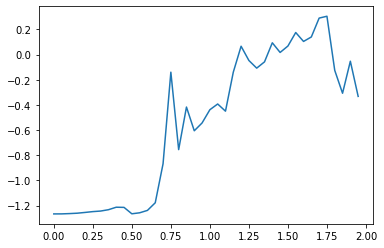

In [41]:
import matplotlib.pyplot as plt

plot_time_dependent_exp_vals(time,energies) #